<a href="https://colab.research.google.com/github/lasupernova/Tensorflow_apps/blob/master/SciAbstractClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An NLP model that makes reading scientific abstract easier by separating an abstract into 5 parts.

 - Background
 - Objectives
 - Methods
 - Results
 - Conclusion

The model aims to replicate and modify (improved) the models built in the following paper:
https://arxiv.org/abs/1710.06071

In [1]:
#check access to GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-e9b71e10-c42c-1526-48a0-a3d763710424)


The PubMed 200k RCT dataset (https://github.com/Franck-Dernoncourt/pubmed-rct)  will be used for training the model, based on the following paper:

https://arxiv.org/abs/1710.06071

In [2]:
#download data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
#download helper function to use throughout script
!wget https://raw.githubusercontent.com/lasupernova/Tensorflow_apps/master/helpers.py

--2021-10-21 22:29:09--  https://raw.githubusercontent.com/lasupernova/Tensorflow_apps/master/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10252 (10K) [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-21 22:29:09 (65.0 MB/s) - ‘helpers.py’ saved [10252/10252]



In [4]:
#imports
import os
import statistics
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import tensorflow_hub as hub
from helpers import calculate_results
import tensorflow as tf

## Model using 10% of data set

In [5]:
#check pubmed_20k_rct dataset files
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


NOTE: <br>
train.txt - train dataset<br>
test.txt - test dataset<br>
dev.txt - validation dataset<br>

In [6]:
DATA_DIR = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [7]:
#get list of filenames in dir
f_names = [f"{DATA_DIR}{os.sep}{f_name}" for f_name in os.listdir(DATA_DIR)]
f_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

### Pre-process data

In [8]:
#read data into variables
def import_data_from_txt(f_name):
  """
  Read data contained in specified file and save data (text) to variable to.

  PARAMS:
    f_name(str) - path to file

  RETURNS:
    data(lst) - list with text data save as entries
  """
  extension = f_name.split(".")[-1]
  if extension != "txt":
    print("ERROR! Extension of type .txt required!")
  with open(f_name, "r") as f:
    return f.readlines()

In [9]:
# for file in f_names:
#   name = file.split("/")[-1].split(".")[0]
#   name = 

In [10]:
train_data = import_data_from_txt('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')
test_data = import_data_from_txt('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')
val_data = import_data_from_txt('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')

In [11]:
train_data[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [12]:
#create list of dicts to store data in 
def preprocess_data(f_name):
    """
    Get information from text file specified.
    Read data contained in data list into list of dicts, with every data list entry being represented by a dict.

    PARAMS:
      f_name(str) - path to file

    RETURNS:
      lstOdct(lst) - list of dicts
    """
    data = import_data_from_txt(f_name)
    line_counter = 0
    lstOdct = []
    for entry in data:
      if entry.startswith("###"):
        line_counter = 1
        new_abstract = []
      elif entry == "\n":
        line_counter = 0
        #get line count for current abstract
        total_lines = len(new_abstract)
        #append line count for current abstract to each dict in sublist
        new_abstract = [dict(item, **{'total_lines':total_lines}) for item in new_abstract]
        #add current abstract entries to lstOdct
        lstOdct.extend(new_abstract)
      else:
        label, sentence = entry.strip().split("\t")
        curr_dict = {
            "line_num" : line_counter,
            "label" : label.lower(),
            "text" : sentence.lower()
        }
        new_abstract.append(curr_dict)
        line_counter  += 1
    return lstOdct

In [13]:
%%time
train_dct = preprocess_data('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')
test_dct = preprocess_data('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')
val_dct = preprocess_data('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')

CPU times: user 584 ms, sys: 116 ms, total: 700 ms
Wall time: 715 ms


In [14]:
train_dct[:5]

[{'label': 'objective',
  'line_num': 1,
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 12},
 {'label': 'methods',
  'line_num': 2,
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 12},
 {'label': 'methods',
  'line_num': 3,
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 12},
 {'label': 'methods',
  'line_num': 4,
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 12},
 {'label': 'methods',
  'line_num': 5,
  'text': 'secondary outcome measures included the western ontari

In [15]:
#convert list of dicts into DataFrame in order to visualize
train_df = pd.DataFrame(train_dct)
test_df = pd.DataFrame(test_dct)
val_df = pd.DataFrame(val_dct)
train_df.head(20)

,line_num,label,text,total_lines
0,1,objective,to investigate the efficacy of @ weeks of dail...,12
1,2,methods,a total of @ patients with primary knee oa wer...,12
2,3,methods,outcome measures included pain reduction and i...,12
3,4,methods,pain was assessed using the visual analog pain...,12
4,5,methods,secondary outcome measures included the wester...,12
5,6,methods,"serum levels of interleukin @ ( il-@ ) , il-@ ...",12
6,7,results,there was a clinically relevant reduction in t...,12
7,8,results,the mean difference between treatment arms ( @...,12
8,9,results,"further , there was a clinically relevant redu...",12
9,10,results,these differences remained significant at @ we...,12


In [16]:
# check what the distribution of abstract length is
len_distrib_sorted = train_df.total_lines.value_counts().sort_values(ascending=False).to_frame()

In [17]:
# check what the distribution of abstract length is
len_distrib = train_df.total_lines.value_counts().to_frame().sort_index()

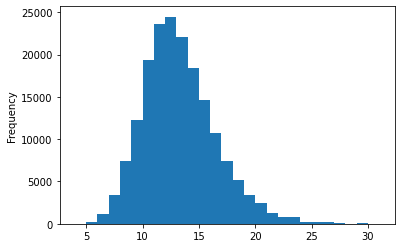

In [18]:
train_df.total_lines.plot.hist(bins=len(len_distrib))
plt.show()

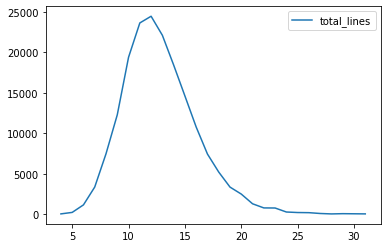

In [19]:
len_distrib.plot()
plt.show()

In [20]:
# check what the distribution of abstract labels is
label_distrib = train_df.label.value_counts()

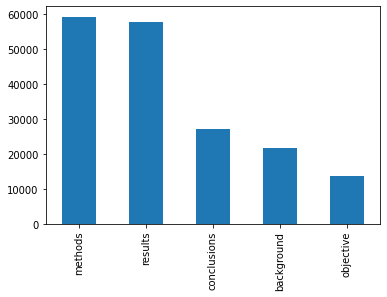

In [21]:
label_distrib.plot(kind="bar")
plt.show() 


### Encode data

 - save text (x) and labels (y) to separate lists to pass on to ML model later on
 -convet labels to numeric form using OneHotEncoding

In [22]:
X_train = train_df["text"].to_list()
X_test = test_df["text"].to_list()
X_val = val_df["text"].to_list()
len(X_train), len(X_test), len(X_val)

(180040, 30135, 30212)

In [23]:
y_train = train_df["label"].to_list()
y_test = test_df["label"].to_list()
y_val = val_df["label"].to_list()
len(y_train), len(y_test), len(y_val)

(180040, 30135, 30212)

In [24]:
X_train[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [25]:
y_train[:5]

['objective', 'methods', 'methods', 'methods', 'methods']

In [26]:
#get indeces -  convert to array to be ableto use with sklearn OneHotEncoder
labels = np.array(y_train)

In [27]:
labels

array(['objective', 'methods', 'methods', ..., 'results', 'conclusions',
       'conclusions'], dtype='<U11')

##### One-hot Encoding

In [28]:
#one hot encode labels - non-sparse matrix in order to be compatible with tf.constant()
enc = OneHotEncoder(sparse=False)

In [29]:
encoded_train_labels = enc.fit_transform(labels.reshape(-1, 1)) #fit to training labels AND trasnform those labels

In [30]:
encoded_train_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [31]:
tf.constant(encoded_train_labels)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [32]:
#use fit_transformed encoder to also trasnform validation and test labels
encoded_test_labels = enc.transform(np.array(y_test).reshape(-1,1)) #encoder was already fitted (to training labels) - transform test and val labels now
encoded_val_labels = enc.transform(np.array(y_val).reshape(-1,1)) 

##### Label Encoding

In [33]:
label_enc = LabelEncoder()
lab_encoded_train_labels = label_enc.fit_transform(labels.reshape(-1, 1))
lab_encoded_test_labels = label_enc.transform(np.array(y_test).reshape(-1,1)) #encoder was already fitted (to training labels) - transform test and val labels now
lab_encoded_val_labels = label_enc.transform(np.array(y_val).reshape(-1,1)) 

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
lab_encoded_train_labels[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

##### Get class names from encoder

--> this could be done with any of the two encoders, but here the information in extracted from OneHotEncoder instance (enc)

In [35]:
#get class names and numbers from label encoder
num_classes = len(label_enc.classes_)
classes = list(label_enc.classes_)
classes

['background', 'conclusions', 'methods', 'objective', 'results']

In [36]:
# ##for labels from onehotencoder: use
# enc.categories_

In [37]:
dir(enc.categories_)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

## Train Models

Different models will be tried, including:<br>
 - sklearn's NaiveBayes (tf-idf) encoder <br>
 - TensorFlow Hub Pretrained Feature Extractor<br>
 - Conv1D with character embeddings<br>
 - Pretrained token embeddings (same as 2nd model from above) + charater embeddings (same as 3rd from above)<br>
 - Pretrained token embeddings (same as 2nd model from above) + charater embeddings (same as 3rd from above) + positional embeddings



### Naive Bayes (tf-idf)

In [38]:
# create model (here: using Pipeline)

baseline_model = Pipeline(
    [
     ("tf-idf", TfidfVectorizer()),
     ("clf", MultinomialNB())
    ]
)


In [39]:
#compile model not needed for sklearn models

In [40]:
#fit model
baseline_model.fit(X=X_train,
                   y=lab_encoded_train_labels #using Label Encoded labels
                   )

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [41]:
#evaluate baseline model -->NOTE: similar to '.evaluate' in keras
baseline_model.score(X=X_val,
                        y=lab_encoded_val_labels)

0.7218323844829869

In [42]:
#make and save predictions using baseline model
baseline_preds = baseline_model.predict(X_val)

In [43]:
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [44]:
baseline_metrics = calculate_results(lab_encoded_val_labels, baseline_preds)

### 1D CNN with Token Embeddings

In [45]:
#info regarding sentence length
train_df['sentence_length'] = train_df.text.apply(lambda x: len(x.split()))
train_df.sentence_length.describe()

count    180040.000000
mean         26.338269
std          15.386803
min           1.000000
25%          16.000000
50%          23.000000
75%          33.000000
max         296.000000
Name: sentence_length, dtype: float64

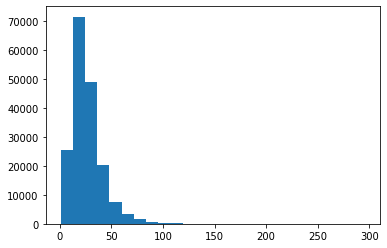

In [46]:
plt.hist(train_df.sentence_length, bins = 25)
plt.show()

In [47]:
#get 75% and 95 % int to use in tokenizer output length
txt_len_75 = int(train_df.sentence_length.describe()['75%'])
txt_len_95 = int(np.percentile(train_df.sentence_length, 95))
txt_len_75, txt_len_95

(33, 55)

NOTE: sentence length spread is quite extreme and there is an abundance of values with more than 33 words, 95% of all sentences fall into the lengths of 55 (or under) --> using 50 words as output length to account for most sentences lengths

In [48]:
out_len = 50
MAX_TOKENS = 68000 #number from Table 2 in paper cited above

In [49]:
#create tokenizer / vectorizerlayer
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS, standardize='lower_and_strip_punctuation',
    split='whitespace', ngrams=None, output_mode='int',
    output_sequence_length=out_len, pad_to_max_tokens=True, vocabulary=None
)
#fit tokenizer to train sentences
vectorizer.adapt(X_train)

In [50]:
#check tokenizer vocab
len(vectorizer.get_vocabulary()), vectorizer.get_vocabulary()[-10:]

(64841,
 ['aarm',
  'aaqol',
  'aaq',
  'aanhui',
  'aana',
  'aainduced',
  'aaigroup',
  'aachener',
  'aachen',
  'aaacp'])

In [51]:
"bioinformatics" in vectorizer.get_vocabulary()

False

In [52]:
#embed
embedder = tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), # set input shape --> = length of vocabulary
                             output_dim=516, # set size of embedding vector,
                             mask_zero=True,
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=out_len) # how long is each input 

In [53]:
random_text = random.choice(X_train)
print(random_text)
print(vectorizer([random_text]))
print(embedder(vectorizer([random_text])))

a prospective randomized single-blind study was designed to analyze @ cases of bilateral crs with np .
tf.Tensor(
[[   8  241   29 1648   17   10  560    6 2283  263    4 1270 5297    7
  4941    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]], shape=(1, 50), dtype=int64)
tf.Tensor(
[[[-0.01693469  0.03022302 -0.02068816 ...  0.02778075  0.00091308
    0.00879723]
  [ 0.00351927  0.04493139  0.02725203 ... -0.01116753 -0.01210303
   -0.00772709]
  [ 0.0287872  -0.04532956 -0.00812922 ... -0.03478686 -0.0451667
   -0.00731688]
  ...
  [-0.04162195  0.02864256  0.01329222 ...  0.03083091 -0.01438066
   -0.00864927]
  [-0.04162195  0.02864256  0.01329222 ...  0.03083091 -0.01438066
   -0.00864927]
  [-0.04162195  0.02864256  0.01329222 ...  0.03083091 -0.01438066
   -0.00864927]]], shape=(1, 50, 516), dtype=float32)


In [54]:
#convert data into tf datasets, so that running efficiency is increased when loading data into model
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, encoded_train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, encoded_test_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, encoded_val_labels))

In [55]:
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [56]:
#create dataset batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [57]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [58]:
#build model - using functional keras
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
x = vectorizer(inputs)
x = embedder(x)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)  #use SOFTMAX for non-binary categorical!!
Conv1D_model = tf.keras.Model(inputs, outputs, name="Conv1D")

In [59]:
#summarize model
Conv1D_model.summary()

Model: "Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 50)                0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 516)           33457956  
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 64)            165184    
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 33,623,465
Trainable params: 33,623,465
Non-trainable params: 0
________________________________________________

In [60]:
#compile
Conv1D_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [61]:
#fit
conv1D_history = Conv1D_model.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=3,
    validation_data=val_dataset,
    validation_steps=int(0.1*len(val_dataset))
)

Epoch 1/3
562/562 [==============================] - 50s 36ms/step - loss: 0.7571 - accuracy: 0.7148 - val_loss: 0.5597 - val_accuracy: 0.7955
Epoch 2/3
562/562 [==============================] - 20s 36ms/step - loss: 0.5701 - accuracy: 0.7900 - val_loss: 0.5490 - val_accuracy: 0.7999
Epoch 3/3
562/562 [==============================] - 20s 35ms/step - loss: 0.5422 - accuracy: 0.8003 - val_loss: 0.5262 - val_accuracy: 0.8012


In [62]:
Conv1D_model.evaluate(val_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5244 - accuracy: 0.8021


[0.5244350433349609, 0.8020985126495361]

In [63]:
!mkdir -p saved_model
Conv1D_model.save('saved_model/Conv1D_model1')

INFO:tensorflow:Assets written to: saved_model/Conv1D_model1/assets


In [64]:
conv1d_preds_probs = Conv1D_model.predict(val_dataset)

In [65]:
conv1d_preds = tf.math.argmax(conv1d_preds_probs, axis=1)

In [66]:
lab_encoded_val_labels

array([0, 0, 3, ..., 4, 1, 1])

In [67]:
conv1D_metrics = calculate_results(lab_encoded_val_labels, conv1d_preds)
conv1D_metrics

{'accuracy': 80.20985039057328,
 'f1': 0.8010133575096982,
 'precision': 0.8021990175458314,
 'recall': 0.8020985039057328}

In [68]:
# conv1D_metrics = {'accuracy': 78.81967430160202,
#  'f1': 0.7859960928563114,
#  'precision': 0.7892146068302194,
#  'recall': 0.7881967430160202}

In [69]:
baseline_metrics

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

Helper functions

In [70]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  PARAMS:
    y_true(np.array) - true labels in the form of a 1D array
    y_pred(np.array) - predicted labels in the form of a 1D array
  RETURNS:
    model_results (dict) - a dictionary of accuracy, precision, recall, f1-score.
  """
  from sklearn.metrics import accuracy_score, precision_recall_fscore_support
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

### Transfer Learning Model: with Tensorflow model + Feature Extraction and pretrained token embeddings

In [71]:
#load pre-trained model as base for this model; feature extraction pnly, so --> not trainable
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], 
                                        dtype=tf.string, 
                                        trainable=False, 
                                        name="use") 

In [72]:
random_text

'a prospective randomized single-blind study was designed to analyze @ cases of bilateral crs with np .'

In [73]:
# check if loaded model works + length of output (=a 512-vector)
len(use_layer([random_text])[0])

512

In [74]:
#build model based on pretrained embedding (use)
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = use_layer(inputs)
x = tf.keras.layers.Dense(128, activation="relu")(pretrained_embedding)
output = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model_pretrained_embedding = tf.keras.Model(inputs, output)

In [75]:
#compile model
model_pretrained_embedding.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [76]:
model_pretrained_embedding.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
use (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [77]:
#fit model
model_pretrained_embedding.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=3,
    validation_data=val_dataset,
    validation_steps=int(0.1*len(val_dataset))
)

Epoch 1/3
562/562 [==============================] - 13s 19ms/step - loss: 0.9192 - accuracy: 0.6503 - val_loss: 0.7972 - val_accuracy: 0.6918
Epoch 2/3
562/562 [==============================] - 10s 19ms/step - loss: 0.7683 - accuracy: 0.7030 - val_loss: 0.7548 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 10s 19ms/step - loss: 0.7505 - accuracy: 0.7138 - val_loss: 0.7385 - val_accuracy: 0.7094


In [78]:
#evaluate model, predict and get performance metrics
model_pretrained_embedding.evaluate(val_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.7400 - accuracy: 0.7132


[0.7400221228599548, 0.7132265567779541]

In [79]:
model_pretrained_embedding_preds = model_pretrained_embedding.predict(val_dataset)

In [80]:
model_pretrained_embedding_preds = np.array(tf.math.argmax(model_pretrained_embedding_preds, axis=1))

In [81]:
model_pretrained_embedding_preds

array([0, 1, 3, ..., 4, 4, 2])

In [82]:
lab_encoded_val_labels

array([0, 0, 3, ..., 4, 1, 1])

In [83]:
model_pretrained_embedding_metrics = calculate_results(lab_encoded_val_labels, model_pretrained_embedding_preds)
model_pretrained_embedding_metrics

{'accuracy': 71.3226532503641,
 'f1': 0.7101309782416974,
 'precision': 0.7131609395597779,
 'recall': 0.713226532503641}

In [84]:
conv1D_metrics

{'accuracy': 80.20985039057328,
 'f1': 0.8010133575096982,
 'precision': 0.8021990175458314,
 'recall': 0.8020985039057328}

### Conv1D with character embeddings

#####  create text vectorizer that works at character-level

In [85]:
#convert word-based sentences into string of individual characters
def sentence_to_char(sentence_list):
  """
  Takes list of sentences and separates all words in each sentece into individual characters
  """
  char_list = [" ".join(list(sentence)) for sentence in sentence_list]  #list(string) - converts string into list of individual characters in the string
  return char_list

In [86]:
X_train_chars = sentence_to_char(X_train)
X_test_chars = sentence_to_char(X_test)
X_val_chars = sentence_to_char(X_val)

In [87]:
#calculate average number of characters in training sentences --> see length in cell below; NOTE:output of this cell also counts introduced whitespace
np.mean([len(sent) for sent in X_train_chars])

297.7325149966674

In [88]:
char_nums = [len(sent) for sent in X_train]

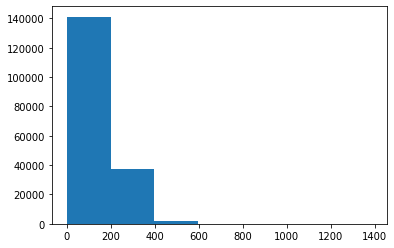

In [89]:
plt.hist(char_nums, bins=7)
plt.show()

In [90]:
#get 75% and 95 % int to use in character tokenizer output length
txt_len_75 = int(np.percentile(char_nums, 75))
txt_len_95 = out_len = int(np.percentile(char_nums, 95))
txt_len_75, txt_len_95

(189, 290)

In [91]:
#max. number of tokens in vectorizer needs to be the max. number of all aplhanumeric characters plus punctuation available
import string
all_chars = string.ascii_lowercase + string.digits + string.punctuation
all_chars

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [92]:
#max number of tokens to use in vectorizer is the number of all_chars PLUS 2 (1 for ' ' and 1 for OOV/['UNK'])
MAX_TOKENS =len(all_chars)
MAX_TOKENS

68

In [93]:
#instantiate
char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS, #number of words in vectorizer vocab
    standardize='lower_and_strip_punctuation',
    split='whitespace', ngrams=None, output_mode='int',
    output_sequence_length=out_len, #number of words each vectorized inpit nis limited to (here: 290, as this captures 95% of all sentence lengths)
    pad_to_max_tokens=True, vocabulary=None,
    name="char_vectorizer"
)

In [94]:
#adapt tp X_train
char_vectorizer.adapt(X_train_chars)

In [95]:
#check vocab
char_vectorizer.get_vocabulary(), len(char_vectorizer.get_vocabulary())

(['',
  '[UNK]',
  'e',
  't',
  'i',
  'a',
  'n',
  'o',
  'r',
  's',
  'd',
  'c',
  'l',
  'h',
  'p',
  'm',
  'u',
  'f',
  'g',
  'y',
  'w',
  'v',
  'b',
  'k',
  'x',
  'z',
  'q',
  'j'],
 28)

##### create embedder that works at char-level and with char-vectorizer

In [96]:
#embed
char_embedder = tf.keras.layers.Embedding(input_dim=len(char_vectorizer.get_vocabulary()), # set input shape --> = length of vocabulary
                             output_dim=25, # set size of embedding vector --> 25 as per model in paper that I am trying to reproduce
                             mask_zero=True,
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=out_len, # how long is each input 
                             name="char_embed")

In [97]:
print(f"Indiv. character sentence: {random_text}")
print(f"Sentence vectorized (with a length of {len(char_vectorizer([random_text])[0])}): \n{char_vectorizer([random_text])}")
print(f"Embedding of vectorized sentence (with a length of {len(char_embedder(char_vectorizer([random_text]))[0][0])} each): \n{char_embedder(char_vectorizer([random_text]))}")
print(f"\nEmbedding shape: \n{char_embedder(char_vectorizer([random_text])).shape}")

Indiv. character sentence: a prospective randomized single-blind study was designed to analyze @ cases of bilateral crs with np .
Sentence vectorized (with a length of 290): 
[[5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0]]
Embedding of vectorized sentence (with a length of 25 each): 
[[[ 0.03941912 -0.01019298  0.00859458 ... -0.0058878  -0.04546351
   -0.03506045]
  [-0.01953325 -0.02792015 -0.00586699 ... -0.00125364  0.00323546
    0.0015577

In [98]:
#create datasets for char-level data (currently only made for word-level data) for faster fitting --> 1) convert data to tf datasets and 2) create batches
train_dataset_char = tf.data.Dataset.from_tensor_slices((X_train_chars, encoded_train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_char = tf.data.Dataset.from_tensor_slices((X_test_chars, encoded_test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_char = tf.data.Dataset.from_tensor_slices((X_val_chars, encoded_val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [99]:
# build model
inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string)  #NOTE: input shape here takes one sequence at the time, whereas use_model embeddings input needed to be a list (specified in use_model docs)
vectorizer = char_vectorizer(inputs)
embedder = char_embedder(vectorizer)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=10, padding="same", activation="relu")(embedder)
x = tf.keras.layers.GlobalMaxPool1D()(x)
output = tf.keras.layers.Dense(num_classes, activation = "softmax")(x)
conv1D_char_embeddings_model = tf.keras.Model(inputs, output, name="conv1D_char_embeddings")

In [100]:
#compile 
conv1D_char_embeddings_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [101]:
#fit --> ONLY on char-based dataset for now
conv1D_char_embeddings_model.fit(
                                 train_dataset_char,
                                 steps_per_epoch=int(0.1*len(train_dataset_char)),
                                 epochs=3,
                                 validation_data=test_dataset_char,
                                 validation_steps=int(0.1*len(val_dataset_char))
                              )

Epoch 1/3
562/562 [==============================] - 7s 11ms/step - loss: 1.2080 - accuracy: 0.5112 - val_loss: 0.9794 - val_accuracy: 0.6283
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.9447 - accuracy: 0.6262 - val_loss: 0.8890 - val_accuracy: 0.6632
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.8620 - accuracy: 0.6648 - val_loss: 0.8067 - val_accuracy: 0.6905


In [102]:
conv1D_char_embeddings_model.evaluate(val_dataset_char)

945/945 [==============================] - 5s 5ms/step - loss: 0.8249 - accuracy: 0.6836


[0.824868381023407, 0.6835694313049316]

In [103]:
conv1D_char_embeddings_preds = conv1D_char_embeddings_model.predict(X_val_chars)

In [104]:
conv1D_char_embeddings_preds = tf.math.argmax(conv1D_char_embeddings_preds, axis=1)

In [105]:
conv1D_char_embeddings_metrics = calculate_results(lab_encoded_val_labels, conv1D_char_embeddings_preds)
conv1D_char_embeddings_metrics

{'accuracy': 68.35694426055872,
 'f1': 0.6749432598794289,
 'precision': 0.6795249160516622,
 'recall': 0.6835694426055872}

In [106]:
baseline_metrics

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [107]:
conv1D_metrics

{'accuracy': 80.20985039057328,
 'f1': 0.8010133575096982,
 'precision': 0.8021990175458314,
 'recall': 0.8020985039057328}

## Multi-modal Models: 1 - character + token - level embedding LSTM <br>

Note: to combine different embedding layers (see 2 of the layers above - xxx and xxx), a "concatenating"-layer (*layers.Concatenate*) needs to be added.

##### Create embedding models for different input types (char vs token - based)

In [108]:
#0. instantiate token - and character-based vectorizers and embedders

#token-level --> using pre-trained embedder (use_model from tf-Hub)
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], #NOTE: required input in list-form --> see model docs
                                        dtype=tf.string, 
                                        trainable=False, 
                                        name="use") 

#char-level
char_out_len = int(np.percentile(char_nums, 95))
MAX_CHARS = len(all_chars)

char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_CHARS, standardize='lower_and_strip_punctuation',
    split='whitespace', ngrams=None, output_mode='int',
    output_sequence_length=char_out_len, pad_to_max_tokens=True, vocabulary=None
)
char_vectorizer.adapt(X_train_chars)

char_embedder = tf.keras.layers.Embedding(input_dim=len(char_vectorizer.get_vocabulary()), 
                             output_dim=516, 
                             mask_zero=True,
                             embeddings_initializer="uniform", 
                             input_length=char_out_len) 


#1. token-level model
token_inputs = tf.keras.layers.Input(shape=[], dtype="string", name="token_inputs")
token_embed_pretrained = use_layer(token_inputs)
token_output = tf.keras.layers.Dense(128, activation="relu")(token_embed_pretrained)  # NOTE: not num_classes for numnb rof units, as this is not the FINAL output layer, but only the token-level output layer before concatination with char-level model
token_model = tf.keras.Model(token_inputs, token_output, name="token_embedding_model")

#2. char-level model
char_inputs = tf.keras.layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vect = char_vectorizer(char_inputs)
char_embed = char_embedder(char_vect)
char_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, dropout=0.2))(char_embed)
char_model = tf.keras.Model(char_inputs, char_output, name="char_embedding_model")

In [109]:
#concatenate two models (token-level and char-level) creatihng a hyrid-token embedding
hybrid_layer = tf.keras.layers.Concatenate(name="hybrid_layer")([token_model.output, char_model.output])

In [110]:
#add output layers incl. drop-out
hybrid_dropout1 = tf.keras.layers.Dropout(0.4, name="hybrid_dropout_1")(hybrid_layer)
hybrid_dense = tf.keras.layers.Dense(128, activation="relu", name="hybrid_dense_layer")(hybrid_dropout1)
hybrid_dropout2 = tf.keras.layers.Dropout(0.6, name="hybrid_dropout_2")(hybrid_dense)
hybrid_output = tf.keras.layers.Dense(num_classes, activation="softmax", name="hybrid_layer_output")(hybrid_dropout2)

In [111]:
#combine all layers into model
hybrid_model = tf.keras.Model([token_inputs, char_inputs], hybrid_output, name="Hybrid_model")  #NOTE: multiple model inputs are ONLY possible with functional API, not with sequential API

In [112]:
hybrid_model.summary()

Model: "Hybrid_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
use (KerasLayer)                (None, 512)          256797824   token_inputs[0][0]               
_______________________________________________________________________________________

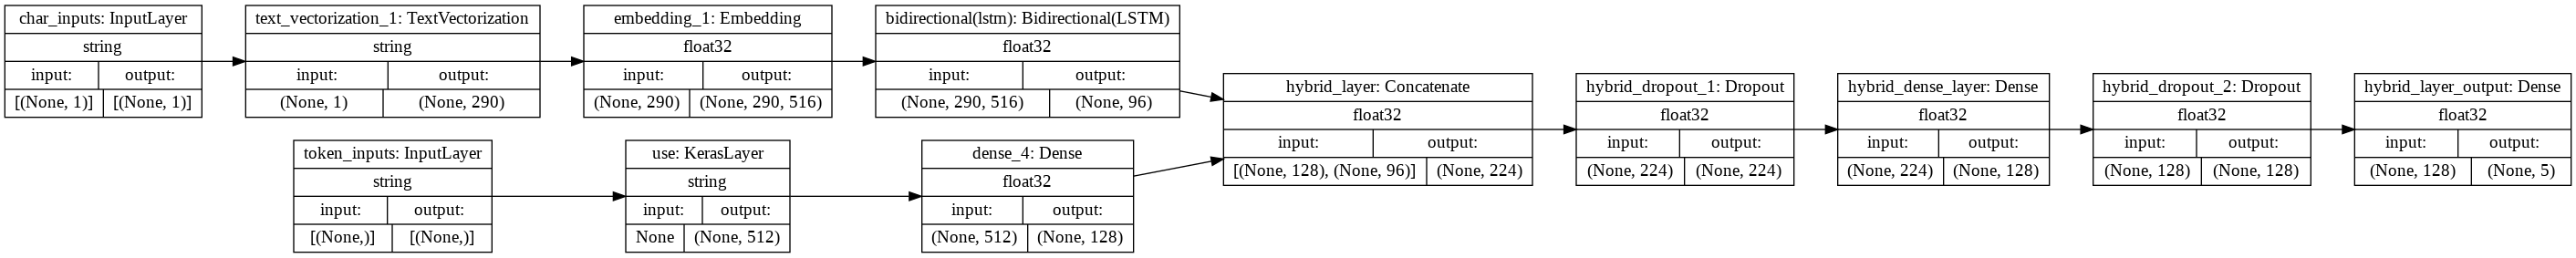

In [113]:
#visualiza more complex models
from tensorflow.keras.utils import plot_model
plot_model(hybrid_model, show_shapes=True, show_dtype=True, rankdir="LR")

In [114]:
#compile model
hybrid_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

We are having input into the modelfrom 2 sources (char and token - based data). <br>
In order to increase efficiency, the two datasets can be combined into on tf.data dataset. This can be done in 3 steps:<br>
 - create features data dataset by passing **features** data from 2 sources (token+char) to from_tensor_slices as a tuple <br>(NOTE: pass the features data in the same order as the data is passed to the tf.keras.layers.Concatenate() layer !) 
 - create label data dataset by passing **encoded labels** data to from_tensor_slices <br>(NOTE: in this case, both datasets have the same labels, so that labels may only passed once instead of in a tuple)
 - combine features using .zip() and label dataset into one tf.data dataset, batch and prefetch<br>

Docs: 
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices 

In [115]:
# combine token and char - level inputs into ONE tf.data dataset to pass to model for train, test and val datasets
train_dataset_hybrid_features = tf.data.Dataset.from_tensor_slices((X_train, X_train_chars)) 
train_dataset_hybrid_labels = tf.data.Dataset.from_tensor_slices(encoded_train_labels) 
train_dataset_hybrid = tf.data.Dataset.zip((train_dataset_hybrid_features, train_dataset_hybrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)  #combine features and labels into dataset and batch+prefetch using .zip()

test_dataset_hybrid_features = tf.data.Dataset.from_tensor_slices((X_test, X_test_chars))  
test_dataset_hybrid_labels = tf.data.Dataset.from_tensor_slices(encoded_test_labels)  
test_dataset_hybrid = tf.data.Dataset.zip((test_dataset_hybrid_features, test_dataset_hybrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset_hybrid_features = tf.data.Dataset.from_tensor_slices((X_val, X_val_chars))  
val_dataset_hybrid_labels = tf.data.Dataset.from_tensor_slices(encoded_val_labels)  
val_dataset_hybrid = tf.data.Dataset.zip((val_dataset_hybrid_features, val_dataset_hybrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [116]:
#fit model
hybrid_model_history = hybrid_model.fit(
    train_dataset_hybrid,
    steps_per_epoch=int(0.1*len(train_dataset_hybrid)),
    batch_size=len(train_dataset_hybrid),
    epochs=3,
    validation_data=val_dataset_hybrid,
    validation_steps=int(0.1*len(val_dataset_hybrid))
)

Epoch 1/3
562/562 [==============================] - 97s 152ms/step - loss: 0.9634 - accuracy: 0.6166 - val_loss: 0.7629 - val_accuracy: 0.7084
Epoch 2/3
562/562 [==============================] - 82s 146ms/step - loss: 0.7933 - accuracy: 0.6941 - val_loss: 0.7076 - val_accuracy: 0.7267
Epoch 3/3
562/562 [==============================] - 77s 138ms/step - loss: 0.7608 - accuracy: 0.7099 - val_loss: 0.6809 - val_accuracy: 0.7424


In [117]:
#evaluate
hybrid_model.evaluate(val_dataset_hybrid)

945/945 [==============================] - 45s 48ms/step - loss: 0.6837 - accuracy: 0.7395


[0.683690071105957, 0.7395405769348145]

In [118]:
#create predictions and get performance metrics

hybrid_model_preds = tf.math.argmax(hybrid_model.predict(val_dataset_hybrid), axis=1)

hybrid_model_metrics = calculate_results(lab_encoded_val_labels, hybrid_model_preds)

hybrid_model_metrics

{'accuracy': 73.95405799020257,
 'f1': 0.7379917264072277,
 'precision': 0.7394988487497496,
 'recall': 0.7395405799020257}

In [119]:
conv1D_metrics

{'accuracy': 80.20985039057328,
 'f1': 0.8010133575096982,
 'precision': 0.8021990175458314,
 'recall': 0.8020985039057328}

## Multi-modal Models: 2 - character + token - level embedding + sentence position <br>

The positional information  was feature-engineered from original data (by preprocessing data using preprocess_data()) and saved in various Python dictionaries (train_dct, test_dct and val_dct). <br><br>
This engineered postional feature will now be added to the model in order to improve performance.

In [120]:
train_df

,line_num,label,text,total_lines,sentence_length
0,1,objective,to investigate the efficacy of @ weeks of dail...,12,49
1,2,methods,a total of @ patients with primary knee oa wer...,12,27
2,3,methods,outcome measures included pain reduction and i...,12,15
3,4,methods,pain was assessed using the visual analog pain...,12,14
4,5,methods,secondary outcome measures included the wester...,12,35
...,...,...,...,...,...
180035,8,results,for the absolute change in percent atheroma vo...,12,95
180036,9,results,"for pav , a significantly greater percentage o...",12,28
180037,10,results,both strategies had acceptable side effect pro...,12,18
180038,11,conclusions,"compared with standard statin monotherapy , th...",12,30


##### Engineer and create positional embeddings<br><br>

Positional embeddings will be created for total lines and line number for each entry.

In [121]:
# calculate position for all dataframes - 
for datframe in [train_df, test_df, val_df]:
  datframe["pos"] = datframe.line_num / datframe.total_lines

In [122]:
val_df.head()

,line_num,label,text,total_lines,pos
0,1,background,ige sensitization to aspergillus fumigatus and...,10,0.1
1,2,background,it is not clear whether these patients would b...,10,0.2
2,3,objective,we sought to determine whether a @-month cours...,10,0.3
3,4,methods,asthmatic patients who were ige sensitized to ...,10,0.4
4,5,methods,primary outcomes were improvement in quality o...,10,0.5


In [123]:
train_pos_feat = np.array(train_df.pos)
test_pos_feat = np.array(test_df.pos)
val_pos_feat = np.array(val_df.pos)

In [133]:
X_train = list(train_df[["text", "pos"]].values)
X_test = list(test_df[["text", "pos"]].values)
X_val = list(val_df[["text", "pos"]].values)
len(X_train), len(X_test), len(X_val)

(180040, 30135, 30212)

In [135]:
#check line number distribution
train_df.line_num.value_counts()

1     15000
2     15000
3     15000
4     15000
5     14992
6     14949
7     14758
8     14279
9     13346
10    11981
11    10041
12     7892
13     5853
14     4152
15     2835
16     1861
17     1188
18      751
19      462
20      286
21      162
22      101
23       66
24       33
25       22
26       14
27        7
28        4
29        3
30        1
31        1
Name: line_num, dtype: int64

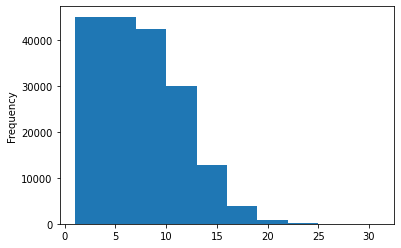

In [136]:
train_df.line_num.plot.hist()

The encoding applied above has the advantage to combine tow metrics (line_num and total_lines) into one, but it has the disadvantage that it suggests to the ML model, that one line number "is bigger" than the other. <br>
By one-hot encoding, line numbers are treated as categorical values and this disadvantage disappears.

In [150]:
# create one-hot-encoding for line numbers
def OHE_line_num(df, feature):
  indices = df[feature].values
  depth = 20  #cutting of line numbers at 20, as most entries have 20 or less lines
  return tf.one_hot(indices, depth)

In [143]:
# NOTE: train_df.line_num.values or train_df.line_num.to_numpy() could both be used in order to create the indices above, as they render the same result (same dtype, same shape)
print(train_df.line_num.values.dtype == train_df.line_num.to_numpy().dtype)
train_df.line_num.values.shape, train_df.line_num.to_numpy().shape

True


((180040,), (180040,))

In [151]:
train_lines_OHE = OHE_line_num(train_df, "line_num")
test_lines_OHE = OHE_line_num(test_df, "line_num")
val_lines_OHE = OHE_line_num(val_df, "line_num")

In [152]:
train_totallines_OHE = OHE_line_num(train_df, "total_lines")
test_totallines_OHE = OHE_line_num(test_df, "total_lines")
val_totallines_OHE = OHE_line_num(val_df, "total_lines")

In [156]:
train_totallines_OHE[:100:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

##### Create, compile, fit and evaluate model **using one-hot encoded (OHE)** positional embeddings


In [188]:
#check entry shape for input in model below
train_lines_OHE[0].shape, train_lines_OHE[0].dtype

(TensorShape([20]), tf.float32)

In [189]:
#0. instantiate token - and character-based vectorizers and embedders

#token-level --> using pre-trained embedder (use_model from tf-Hub)
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], #NOTE: required input in list-form --> see model docs
                                        dtype=tf.string, 
                                        trainable=False, 
                                        name="use") 

#char-level
char_out_len = int(np.percentile(char_nums, 95))
MAX_CHARS = len(all_chars)

char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_CHARS, standardize='lower_and_strip_punctuation',
    split='whitespace', ngrams=None, output_mode='int',
    output_sequence_length=char_out_len, pad_to_max_tokens=True, vocabulary=None
)
char_vectorizer.adapt(X_train_chars)

char_embedder = tf.keras.layers.Embedding(input_dim=len(char_vectorizer.get_vocabulary()), 
                             output_dim=516, 
                             mask_zero=True,
                             embeddings_initializer="uniform", 
                             input_length=char_out_len) 

#1. create all necessary sub-models
#a. token-level model
token_inputs = tf.keras.layers.Input(shape=[], dtype="string", name="token_inputs")
token_embed_pretrained = use_layer(token_inputs)
token_output = tf.keras.layers.Dense(128, activation="relu")(token_embed_pretrained)  # NOTE: not num_classes for numnb rof units, as this is not the FINAL output layer, but only the token-level output layer before concatination with char-level model
token_model = tf.keras.Model(token_inputs, token_output, name="token_embedding_model")

#b. char-level model
char_inputs = tf.keras.layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vect = char_vectorizer(char_inputs)
char_embed = char_embedder(char_vect)
char_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, dropout=0.2))(char_embed)
char_model = tf.keras.Model(char_inputs, char_output, name="char_embedding_model")

#c. line_number-level model
line_num_inputs = tf.keras.layers.Input(shape=(20,),  dtype=tf.float32, name="line_num_inputs")
line_num_output = tf.keras.layers.Dense(units=64, activation="relu")(line_num_inputs)  #NOTE: a Dense layer on its own acts like an embedding itself
line_num_model = tf.keras.Model(line_num_inputs, line_num_output, name="line_num_model")

#d. total_lines-level model
total_lines_inputs = tf.keras.layers.Input(shape=(20, ), dtype=tf.float32, name="total_lines_inputs")
total_lines_output = tf.keras.layers.Dense(units=64, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_output, name="total_lines_model")

In [194]:
char_model.summary();
total_lines_model.summary();

Model: "char_embedding_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
char_inputs (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization_9 (TextVe (None, 290)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 290, 516)          14448     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 96)                216960    
Total params: 231,408
Trainable params: 231,408
Non-trainable params: 0
_________________________________________________________________
Model: "total_lines_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
total_lines_inputs (InputLay [(None, 20)]              0         
_____________

In [203]:
#concatenate string-based models (token, char) creating a hyrid-token embedding
hybrid_layer_string = tf.keras.layers.Concatenate(name="hybrid_layer_string")([token_model.output, 
                                                                               char_model.output])

In [208]:
#add output layers incl. drop-out to string-based-hybrid layer (again, reproducing the workflow of the paper)
hybrid_dropout1 = tf.keras.layers.Dropout(0.4, name="hybrid_dropout_1")(hybrid_layer_string)
hybrid_dense = tf.keras.layers.Dense(128, activation="relu", name="hybrid_dense_layer")(hybrid_dropout1)
hybrid_dropout2 = tf.keras.layers.Dropout(0.6, name="hybrid_dropout_2")(hybrid_dense)

In [209]:
#concatenate 3 models (string-based-hybrid, line_num and total_lines) creating a tririd-token embedding
hybrid_layer4 = tf.keras.layers.Concatenate(name="hybrid4_layer")([line_num_model.output,
                                                                 total_lines_model.output,
                                                                 hybrid_dropout2]) #already a concatenated object -- use directlz instead of object output

In [210]:
# create output layer
hybrid4_output = tf.keras.layers.Dense(num_classes, activation="softmax", name="hybrid4_layer_FINALoutput")(hybrid_layer4)

In [216]:
#combine into one model with all necessary inputs
hybrid4_model = tf.keras.Model([line_num_model.input, total_lines_model.input, token_model.input, char_model.input], outputs=hybrid4_output, name="Hybrid4_model")    #token_model.input and token_model_inputs are interchangeable

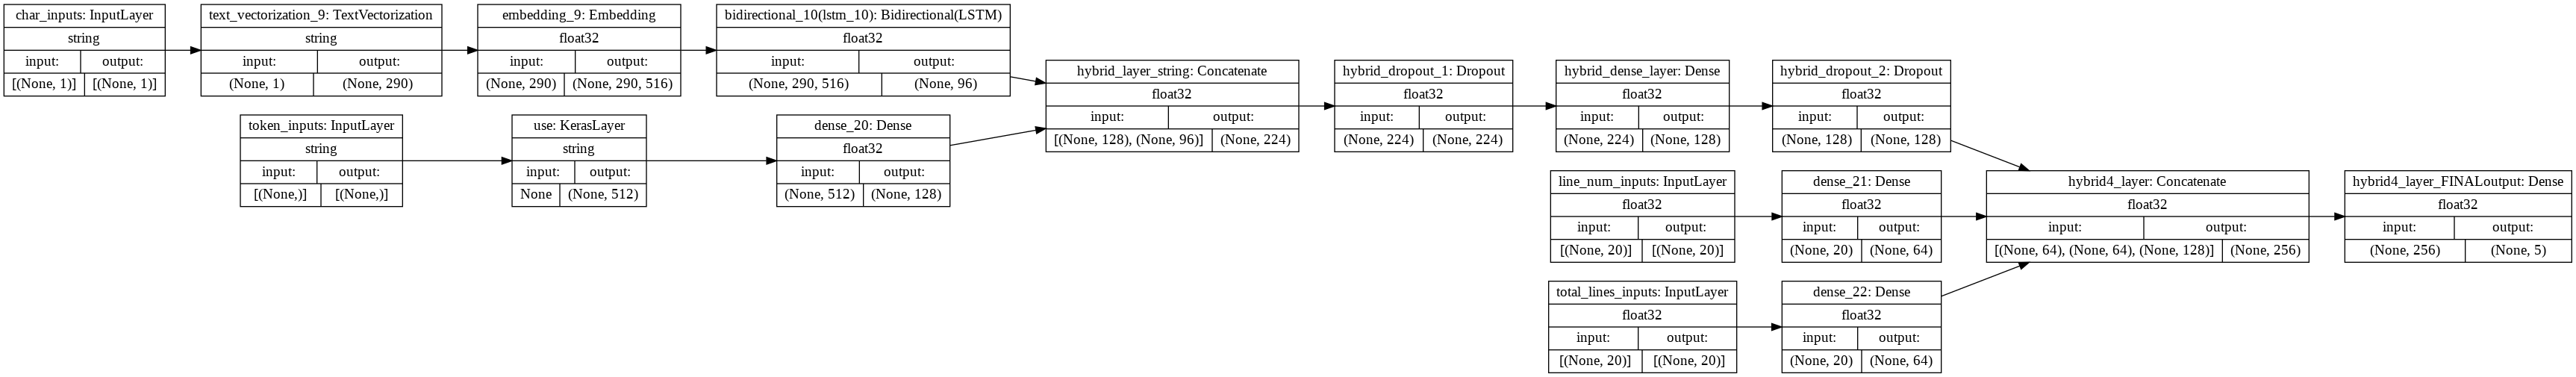

In [217]:
#plot model for visual exploration
plot_model(hybrid4_model, show_shapes=True, show_dtype=True, rankdir="LR")

In [218]:
hybrid4_model.summary()

Model: "Hybrid4_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization_9 (TextVecto (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
use (KerasLayer)                (None, 512)          256797824   token_inputs[0][0]               
______________________________________________________________________________________